In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [2]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train.count()

id               159571
comment_text     159571
toxic            159571
severe_toxic     159571
obscene          159571
threat           159571
insult           159571
identity_hate    159571
dtype: int64

In [4]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

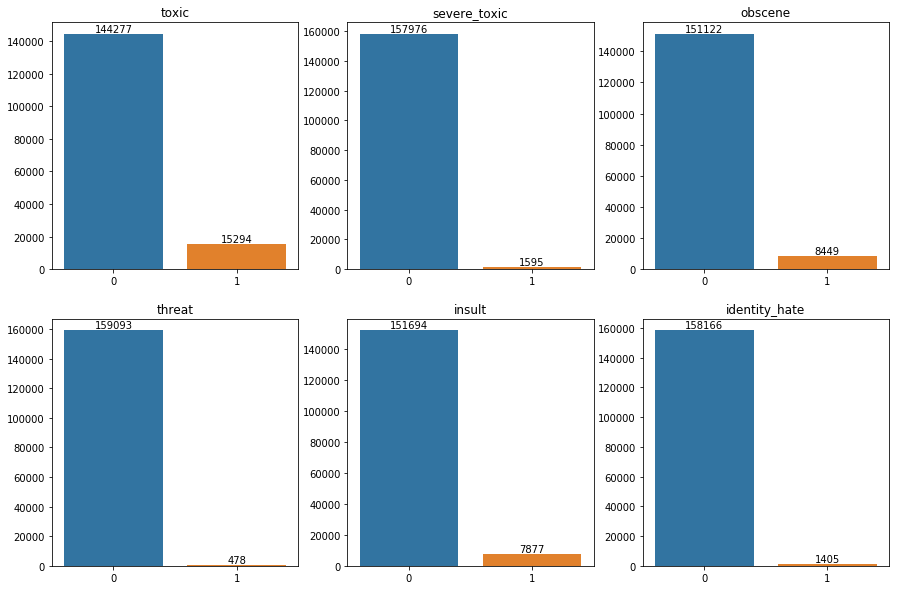

In [6]:
category = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
ncat = len(category)
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
for i in range(ncat):
    sub_cat_total = train[category[i]].value_counts()
    sns.barplot(x = sub_cat_total.index, y = sub_cat_total.values, ax = ax[int(i/3)][i%3])
    ax[int(i/3)][i%3].set_title(category[i])
    rects = ax[int(i/3)][i%3].patches
    labels = sub_cat_total.values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax[int(i/3)][i%3].text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = "center", va = "bottom")

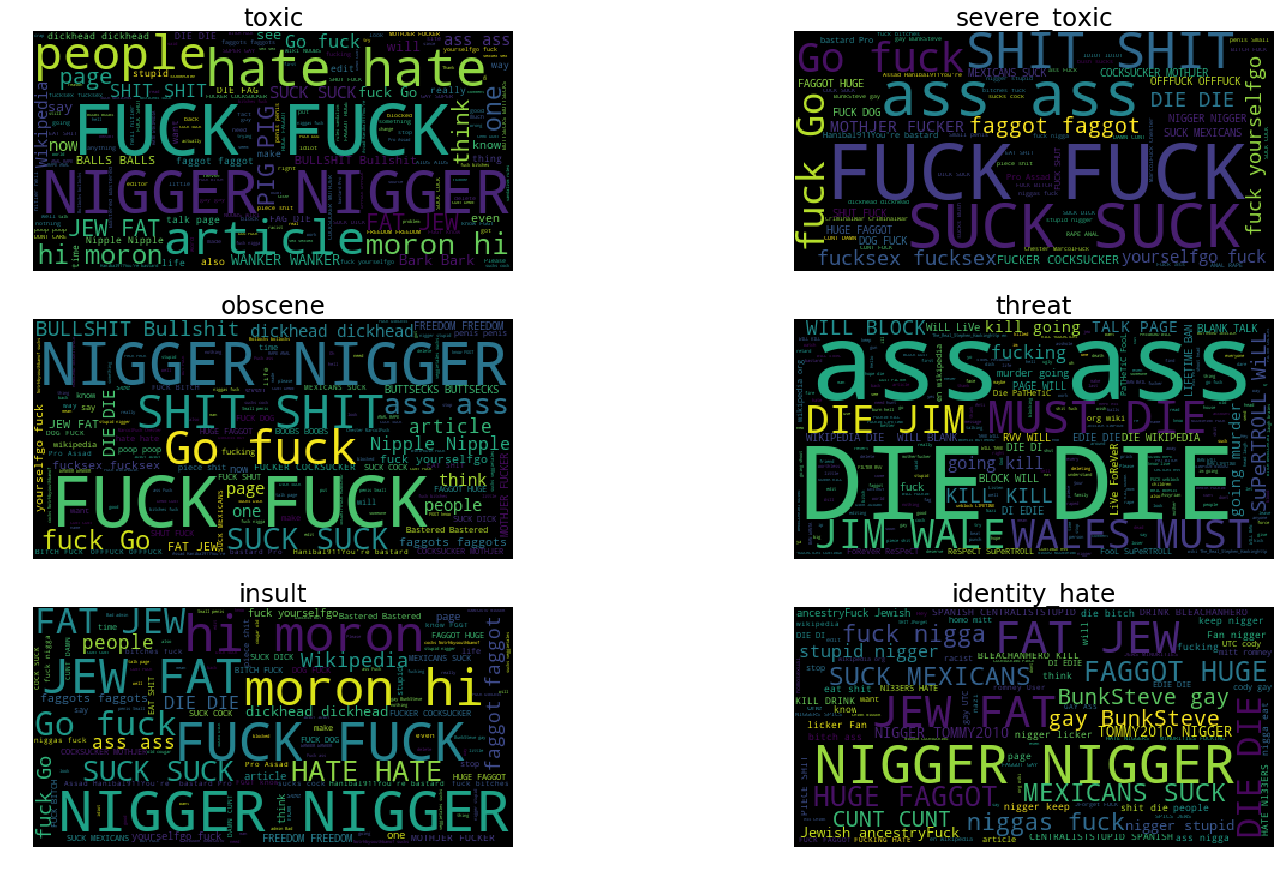

In [7]:
from wordcloud import WordCloud

fig, ax = plt.subplots(3, 2, figsize = (25, 15))
for i in range(ncat):
    wordcloud = WordCloud(max_words = 1000
                         ).generate(" ".join(train["comment_text"][train[category[i]] == 1].astype(str)))
    ax[int(i/2)][i%2].axis("off")
    ax[int(i/2)][i%2].imshow(wordcloud)
    ax[int(i/2)][i%2].set_title(category[i], fontsize = 25)
plt.show()

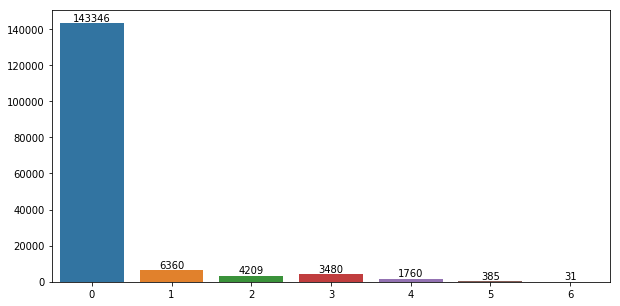

In [8]:
train["multiple"] = train.iloc[:, 2:].sum(axis = 1)
mul_cat = train["multiple"].value_counts()
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = mul_cat.index, y = mul_cat.values)

rects = ax.patches
labels = mul_cat.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = "center", va = "bottom")
plt.show()

In [9]:
from nltk.stem import SnowballStemmer, PorterStemmer, WordNetLemmatizer

# stemmer = SnowballStemmer("english")
lemm = WordNetLemmatizer()

def stem_text(line):
    line = line.split(" ")
#     stemmed_words = [stemmer.stem(word) for word in line]
    stemmed_words = [lemm.lemmatize(word) for word in line]
    line = " ".join(stemmed_words)
    return line

train["comment_text"] = train["comment_text"].apply(stem_text)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def ngrams(data, n):
    tf = TfidfVectorizer(min_df = 100, max_features = 100000, 
                strip_accents = "unicode", analyzer = "word", ngram_range = (n, n),
                use_idf = 1, smooth_idf = 1, sublinear_tf = 1,
                stop_words = "english")
    tf.fit(data["comment_text"])
    features = np.array(tf.get_feature_names())
    unigrams =  tf.transform(data["comment_text"].astype("U"))
    return unigrams, features

train_unigrams, features = ngrams(train, 1)

In [11]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    train_tags = train.iloc[:, 2:]
    cols = train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.col = col
        dfs.append(feats_df)
    return dfs

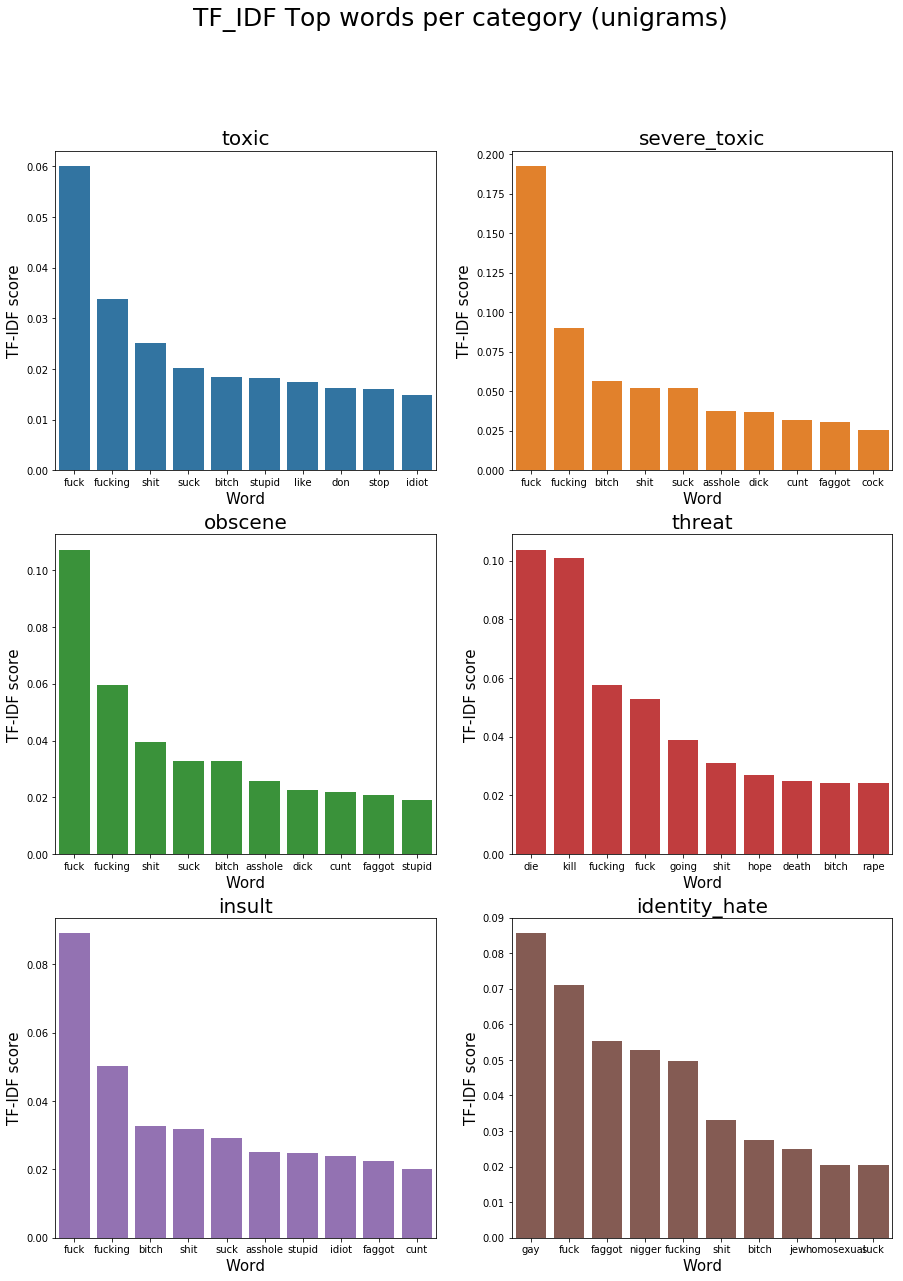

In [12]:
tfidf_top_n_per_lass = top_feats_by_class(train_unigrams, features)
color = sns.color_palette()
fig, ax = plt.subplots(3, 2, figsize = (15, 20))
fig.suptitle("TF_IDF Top words per category (unigrams)", fontsize = 25)
for i in range(ncat):
    sns.barplot(tfidf_top_n_per_lass[i].feature.iloc[0:10], tfidf_top_n_per_lass[i].tfidf.iloc[0:10], 
                ax = ax[int(i/2)][i%2], color = color[i])
    ax[int(i/2)][i%2].set_title(category[i], fontsize = 20)
    ax[int(i/2)][i%2].set_xlabel("Word", fontsize = 15)
    ax[int(i/2)][i%2].set_ylabel("TF-IDF score", fontsize = 15)

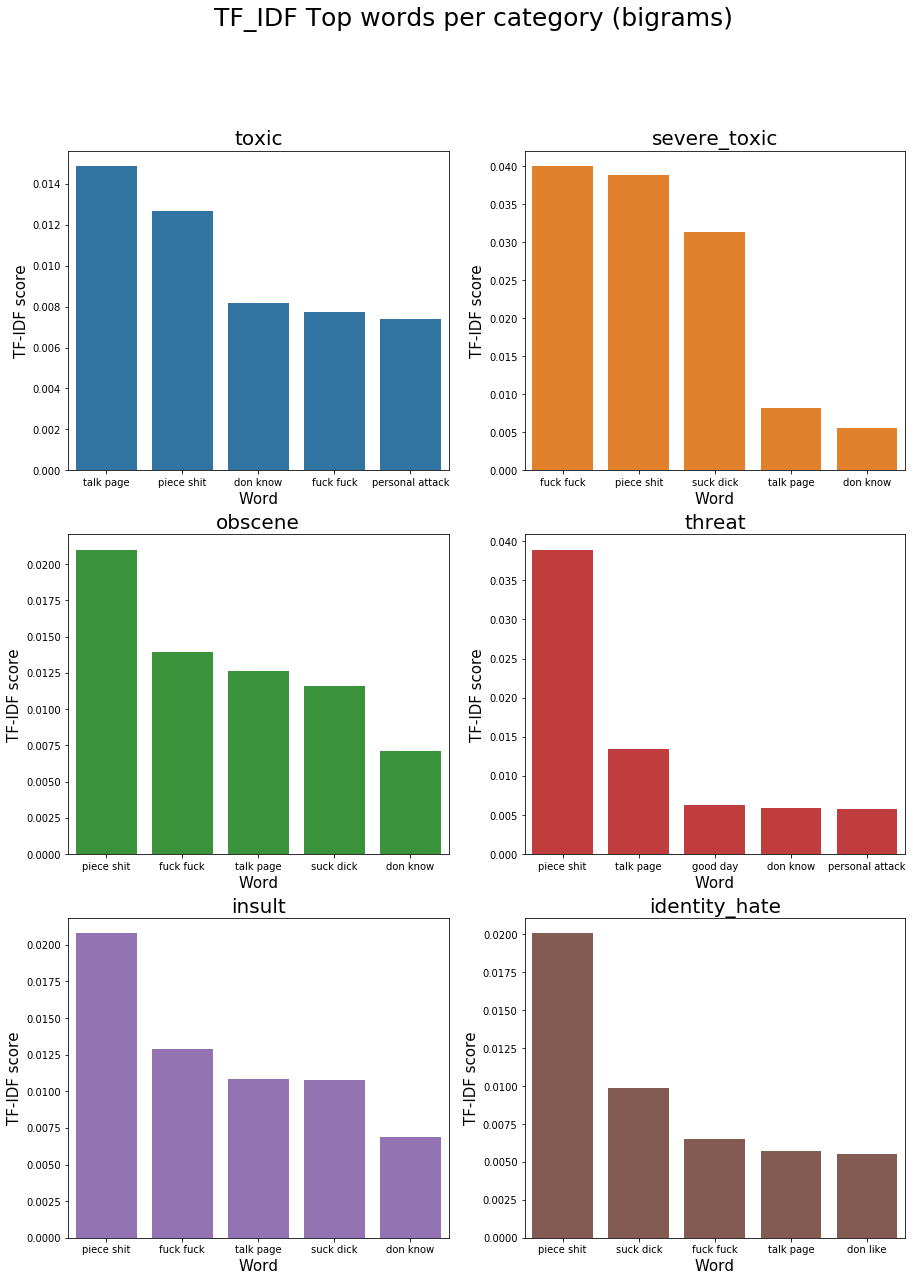

In [13]:
train_bigrams, features = ngrams(train, 2)

tfidf_top_n_per_lass = top_feats_by_class(train_bigrams, features)
color = sns.color_palette()
fig, ax = plt.subplots(3, 2, figsize = (15, 20))
fig.suptitle("TF_IDF Top words per category (bigrams)", fontsize = 25)
for i in range(ncat):
    sns.barplot(tfidf_top_n_per_lass[i].feature.iloc[0:5], tfidf_top_n_per_lass[i].tfidf.iloc[0:5], 
                ax = ax[int(i/2)][i%2], color = color[i])
    ax[int(i/2)][i%2].set_title(category[i], fontsize = 20)
    ax[int(i/2)][i%2].set_xlabel("Word", fontsize = 15)
    ax[int(i/2)][i%2].set_ylabel("TF-IDF score", fontsize = 15)

In [14]:
train["comment_length"] = train.comment_text.apply(len)

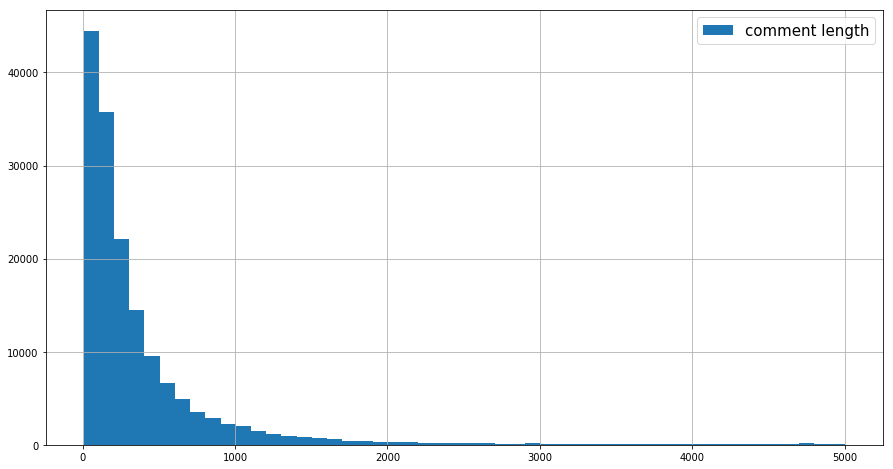

In [15]:
plt.figure(figsize = (15, 8))
train.comment_length.hist(bins = 50, label = "comment length")
plt.legend(fontsize = 15)
plt.show()

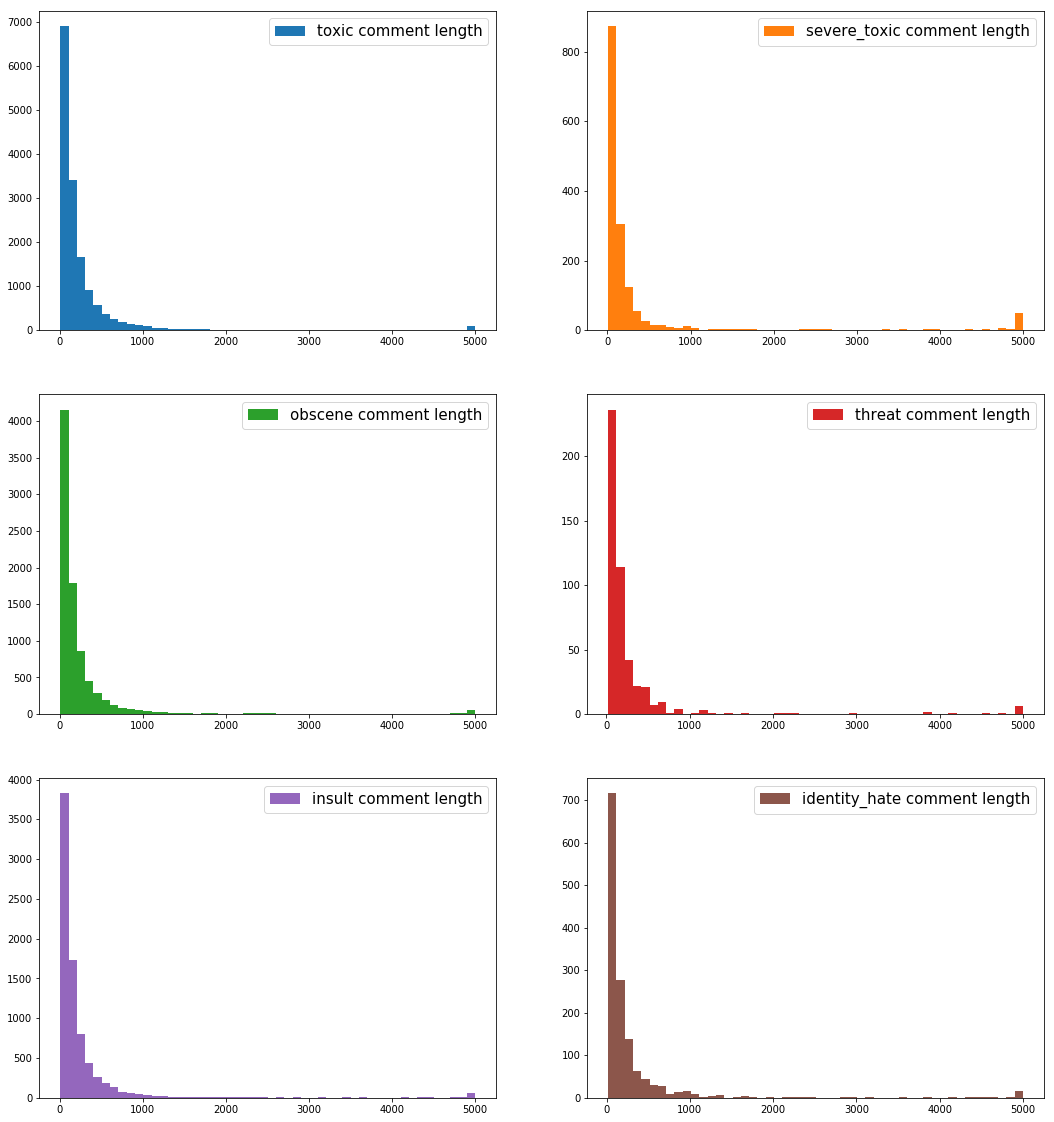

In [16]:
fig, ax = plt.subplots(3, 2, figsize = (18, 20))
for i in range(ncat):
    cat = category[i]
    ax[int(i/2)][i%2].hist(train[train[cat] == 1]["comment_length"], bins = 50, facecolor = color[i],
                           label = cat + " comment length")
    ax[int(i/2)][i%2].legend(fontsize = 15)
plt.show()

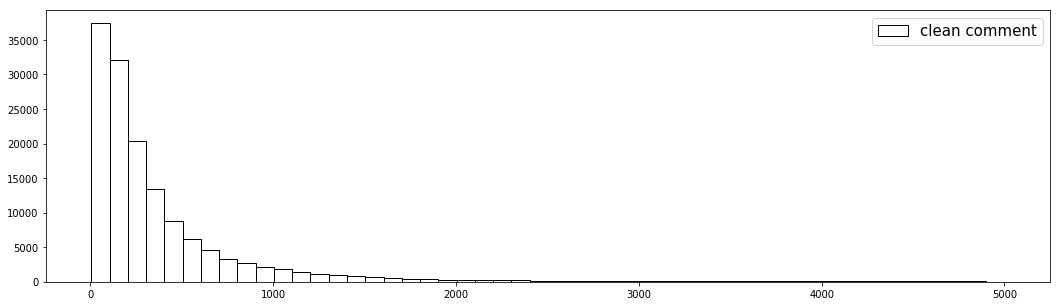

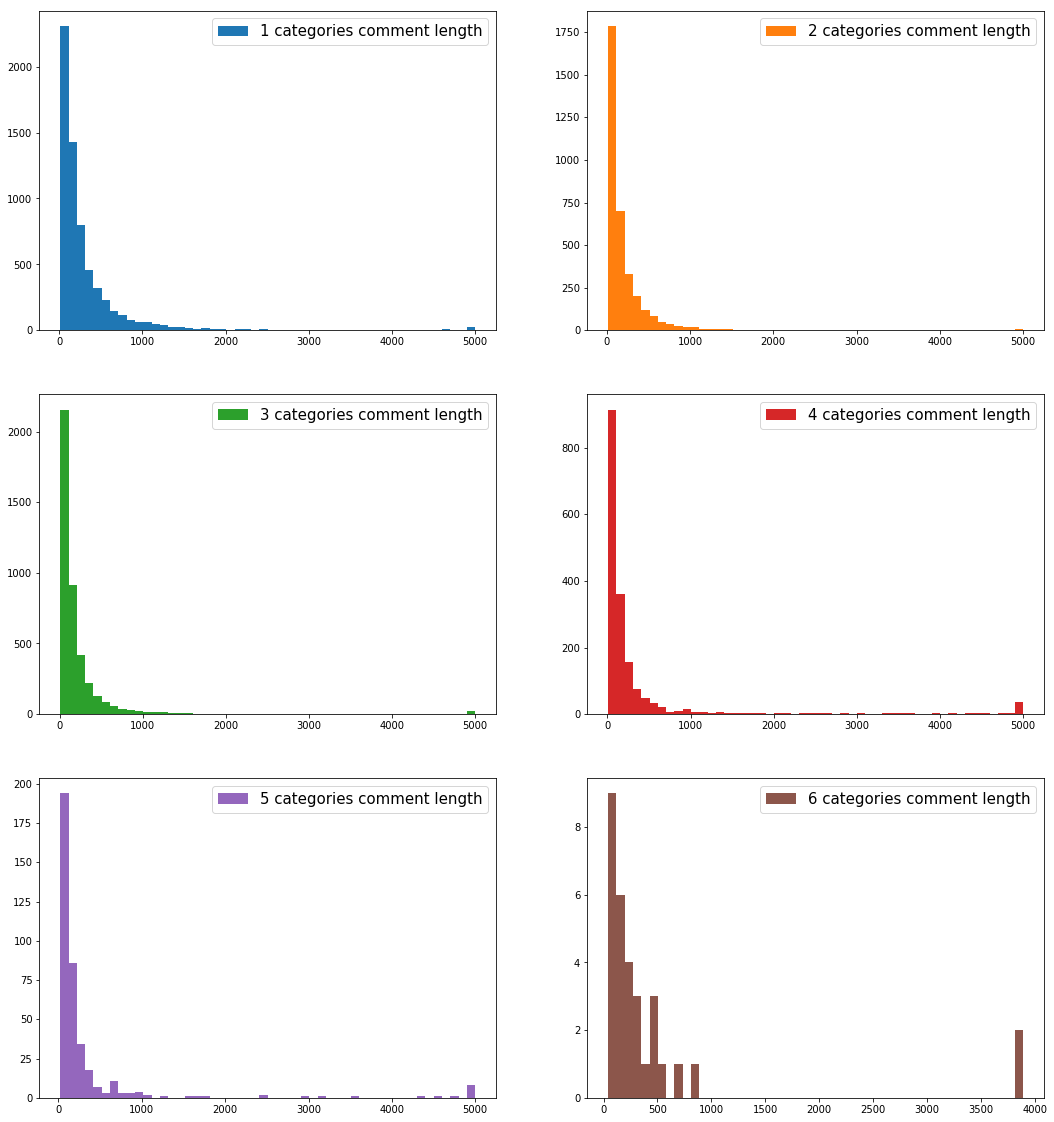

In [17]:
plt.figure(figsize = (18, 5))
plt.hist(train[train["multiple"] == 0]["comment_length"], bins = 50, facecolor = "white", ec = "black",
         label = "clean comment")
plt.legend(fontsize = 15)
fig, ax = plt.subplots(3, 2, figsize = (18, 20))
for i in range(0, ncat):
    ax[int(i/2)][i%2].hist(train[train["multiple"] == i + 1]["comment_length"], bins = 50, facecolor = color[i],
                           label = str(i + 1) + " categories comment length")
    ax[int(i/2)][i%2].legend(fontsize = 15)
plt.show()

In [18]:
import string

def isEnglish(s):
    try:
        s.encode(encoding = "utf-8").decode("ascii")
    except UnicodeDecodeError:
        return False
    else:
        return True

print("[{}] comments are not English".format(list(test["comment_text"].apply(isEnglish)).count(False)))

[17915] comments are not English


In [19]:
test["comment_text"] = test["comment_text"].apply(stem_text)

In [20]:
test["comment_text"][0]

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white face and get you to kiss my as you guy sicken me. Ja rule is about pride in da music man. dont dis that shit on him. and nothin is wrong bein like tupac he wa a brother too...fuckin white boy get thing right next time.,"